## Sentimental analysis for IMDb reviews

In this notebook we will look at sentimental analysis of user reviews from IMDb:
* We have 13635 reviews for the 1304 movies that were common between our dataset and the dataset that contained the reviews.
* The original reviews dataset is available [here.](http://ai.stanford.edu/~amaas/data/sentiment/) It contains 100.000 reviews from IMDb. [Citation.](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.bib)
* We will plot the sentimental score of the reviews for our movies, we will also plot the sentimental score of a movie against the IMDb rating of said movie and check if there is any correlation.
* Lastly we will check the correlation of the sentimental score of a review and the reviewer's rating of the movie, this part will use all reviews that have a rating (50.000 reviews).

First let's get the data we need and import all packages we will be using.

In [91]:
%matplotlib inline
from __future__ import division
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from math import floor, log10
import matplotlib.pyplot as plt
import numpy as np
import re
import urllib2
import csv
import os
import nltk
import heapq
import json
import string
import io

# Function used to round numbers to n significant numbers
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

### Data
As the reviews in the dataset is linked to a IMDb ID of the review's movie we need to get the title as our TMDb dataset does not include IMDb IDs of the movies. We do this by scraping IMDb for the title of the movies, we use regular expression to get what we are interested in from the movie's page.

First we get the IMDb IDs.

In [2]:
#Lets get all the URLs for the reviews
imdb_ids = []
with open('aclImdb/test/urls_neg.txt') as f:
    for line in f:
        imdb_ids.append(line.split('/')[4])
        
with open('aclImdb/test/urls_pos.txt') as f:
    for line in f:
        imdb_ids.append(line.split('/')[4])
        
with open('aclImdb/train/urls_neg.txt') as f:
    for line in f:
        imdb_ids.append(line.split('/')[4])
        
with open('aclImdb/train/urls_pos.txt') as f:
    for line in f:
        imdb_ids.append(line.split('/')[4])
        
with open('aclImdb/train/urls_unsup.txt') as f:
    for line in f:
        imdb_ids.append(line.split('/')[4])


Now for the actual scraping, this will be commented out as to make sure this will not be re-run as it takes multiple hours. We are doing ~14.000 requests to IMDb, we tried doing this in multiprocessing but that resulted in IMDb 'blacklisting' us as we couldn't access their site for the next 30 minutes after. I guess they thought we were trying a DDoS attack on them. We wrote the data to a file afterwards so that we could access it again.

In [3]:
#Scraping for the title of our IMDb IDs

#set_ids = set(imdb_ids)
#id_to_title = {}
#counter = 0

#for i in set_ids:
#    try:
#        counter += 1
#        response = urllib2.urlopen('http://www.imdb.com/title/'+ i + '/')
#        html = response.read()
#        found = re.findall(b"""<meta property=\'og:title\' content=\"(.*)\"""", html)
#        id_to_title[i] = found[0][:-7]
#        print(counter)
#    except:
#        print('Failed: ' + i)


In [4]:
#Write the result to a file
#with open('id_to_title_w_year.txt', 'a') as out:
#    for i in id_to_title:
#        out.write(i + '\\' + str(id_to_title[i]) + '\n')

Read the data from the file as to not scrape again.

In [5]:
#Get the data from the file(this is simply to not have to run the scraping each time, takes many hours)
title_to_id = {}
with open('id_to_title_w_year.txt') as f:
    for line in f:
        title = line.split('\\')[1]
        imdb_id = line.split('\\')[0]
        if title:
            #Get rid of trailing spaces
            if title[-1] == ' ':
                title_to_id[title[:-1]] = imdb_id
            else:
                title_to_id[title] = imdb_id

The scraping did not go perfectly as the titles differed a bit in format. A movie title could look like 'The Lost World: Jurassic Park (1997)' while a title for a TV series or a TV movie could look like 'Planet Earth II (TV Mini-Series 2016)'. We therefore do a bit of cleaning here.

In [6]:
tmp_dict = {}
#As IMDb include year and info if it's a TV movie/series in the title we need to tidy it up a bit
for ti in title_to_id:
    if '(' in ti and ')' not in ti:
        tmp_dict[ti[:ti.index('(')-1]] = title_to_id[ti]
    else:
        tmp_dict[ti[:-1]] = title_to_id[ti]
title_to_id = tmp_dict

Now let's get the titles of our movies.

In [7]:
#Get the titles of the 5000 movies we have in our dataset
movie_titles = []
with open('tmdb_5000_movies.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        movie_titles.append(row['title'])

Let's find common movies.

In [8]:
#Find common movies, that is movies that are both in our dataset and we have reviews for
common_movies = {}
for i in movie_titles:
    if i in title_to_id:
        common_movies[title_to_id[i]] = i
print(len(common_movies))

1304


The layout of the files in the reviews dataset was that it was split into 'train' and 'test' sets that each was then split into 'pos', 'neg' and 'unsup' files. That stands for positive, negative and reviews that had 0 in rating.

In [9]:
#Get all the file names for our reviews and sort them
train_pos = []
list_of_files = []
for filename in os.listdir('aclImdb/train/pos'):
    list_of_files.append((int(filename.split('_')[0]),filename))
    
tmp_list = sorted(list_of_files)
for i in tmp_list:
    train_pos.append(i[1])

train_neg = []
list_of_files = []
for filename in os.listdir('aclImdb/train/neg'):
    list_of_files.append((int(filename.split('_')[0]),filename))
    
tmp_list = sorted(list_of_files)
for i in tmp_list:
    train_neg.append(i[1])
    
train_unsup = []
list_of_files = []
for filename in os.listdir('aclImdb/train/unsup'):
    list_of_files.append((int(filename.split('_')[0]),filename))
    
tmp_list = sorted(list_of_files)
for i in tmp_list:
    train_unsup.append(i[1])
    
test_pos = []
list_of_files = []
for filename in os.listdir('aclImdb/test/pos'):
    list_of_files.append((int(filename.split('_')[0]),filename))
    
tmp_list = sorted(list_of_files)
for i in tmp_list:
    test_pos.append(i[1])
    
test_neg = []
list_of_files = []
for filename in os.listdir('aclImdb/test/neg'):
    list_of_files.append((int(filename.split('_')[0]),filename))
    
tmp_list = sorted(list_of_files)
for i in tmp_list:
    test_neg.append(i[1])
    

In [95]:
#Here we loop through each file and collect the review text in a dictionary where the key is
# the movie title and the value is a list of strings, where each string is a review
list_index = 0
review_dict = {}
filename_to_review = {}
for filename in test_neg:
    with io.open('aclImdb/test/neg/' + filename, encoding='utf-8') as f:
        for line in f:
            filename_to_review['test/neg/' + filename] = line
            if imdb_ids[list_index] in common_movies:
                if common_movies[imdb_ids[list_index]] in review_dict:
                    review_dict[common_movies[imdb_ids[list_index]]].append(line)
                else:
                    review_dict[common_movies[imdb_ids[list_index]]] = [line]
    list_index += 1
            
for filename in test_pos:
    with io.open('aclImdb/test/pos/' + filename, encoding='utf-8') as f:
        for line in f:
            filename_to_review['test/pos/' + filename] = line
            if imdb_ids[list_index] in common_movies:
                if common_movies[imdb_ids[list_index]] in review_dict:
                    review_dict[common_movies[imdb_ids[list_index]]].append(line)
                else:
                    review_dict[common_movies[imdb_ids[list_index]]] = [line]
    list_index += 1
        
for filename in train_neg:
    with io.open('aclImdb/train/neg/' + filename, encoding='utf-8') as f:
        for line in f:
            filename_to_review['trai/neg/' + filename] = line
            if imdb_ids[list_index] in common_movies:
                if common_movies[imdb_ids[list_index]] in review_dict:
                    review_dict[common_movies[imdb_ids[list_index]]].append(line)
                else:
                    review_dict[common_movies[imdb_ids[list_index]]] = [line]
    list_index += 1
            
for filename in train_pos:
    with io.open('aclImdb/train/pos/' + filename, encoding='utf-8') as f:
        for line in f:
            filename_to_review['trai/pos/' + filename] = line
            if imdb_ids[list_index] in common_movies:
                if common_movies[imdb_ids[list_index]] in review_dict:
                    review_dict[common_movies[imdb_ids[list_index]]].append(line)
                else:
                    review_dict[common_movies[imdb_ids[list_index]]] = [line]
    list_index += 1
            
for filename in train_unsup:
    with io.open('aclImdb/train/unsup/' + filename, encoding='utf-8') as f:
        for line in f:
            if imdb_ids[list_index] in common_movies:
                if common_movies[imdb_ids[list_index]] in review_dict:
                    review_dict[common_movies[imdb_ids[list_index]]].append(line)
                else:
                    review_dict[common_movies[imdb_ids[list_index]]] = [line]
    list_index += 1
        

Get data from Data_Set_S1 to use in our happiness ranking.

In [93]:
# counter to count the number of lines that have been processed
counter = 0

happyness_rank = defaultdict(float)
path = 'Data_Set_S1.txt'
with io.open(path, encoding='utf-8') as f:
    for line in f:
        counter += 1
        
        # we want to skip the first 4 lines of the file
        if counter > 4:
            line = line.split()
            word = line[0]  # get the word from the line
            happiness_average = float(line[2]) # get the word happiness average
            happyness_rank[word] = happiness_average

In [13]:
# Takes in a list of tokens and the happiness_keys which is the list of words in data set 1
# returns the mean value of the happiness rank that was found in the tokens array
# if no value was found then the function returns None
def estimateHappiness(tokens,happiness_keys):
    
    happiness_avg = [] # an array that contains the average happyness values of the tokens
    
    for token in tokens:
        # only include the words that can be found in the data set
        if token in happiness_keys: 
            happiness_avg.append(happyness_rank[token])
            
    # If no word in the tokens array is found in the dataset then we return 0
    if len(happiness_avg) == 0:
        return None
    else : 
        return np.mean(happiness_avg)

In [96]:
#We want to calculate average sentiment score of all reviews for a movie and also store the result in a dictionary
movie_score_list = []
movie_score_dict = {}
tokenizer = RegexpTokenizer(r'\w+')
happiness_keys = set(happyness_rank.keys())

for movie in review_dict:
    sum_of_scores = 0.0
    try:
        for i in review_dict[movie]:
            #Get all tokens with the tokenizer
            tokens = tokenizer.tokenize(i.lower())
            #Filter out the stop words and digits
            filtered_words = [w for w in tokens if not w in stopwords.words('english') if not w.isdigit()]
            sum_of_scores += estimateHappiness(filtered_words,happiness_keys)
        movie_score_list.append((sum_of_scores/len(review_dict[movie]), movie))
        movie_score_dict[movie] = sum_of_scores/len(review_dict[movie])
    except UnicodeError:
        print i

In [97]:
#Find the top
top6 = heapq.nlargest(6, movie_score_list)

print ("{name_s: <46} {sentiment_d: <14}".format(
            name_s = "Movie:", sentiment_d = "Sentiment score:"
        ))

print("---------------------------------------------------------------")

for value in top6:
    print ("{name_s: <46} {sentiment_d: <14}".format(
            name_s = value[1], sentiment_d = round_sig(value[0],5)
        ))

Movie:                                         Sentiment score:
---------------------------------------------------------------
Remember Me                                    6.2013        
Joe Dirt                                       6.1993        
Trekkies                                       6.1763        
Logan's Run                                    6.172         
Love Jones                                     6.1141        
Superman                                       6.1021        


Here we can see for which movies we have the 'happiest' reviews. If we look at their rating; 7.2, 7.0, 6.8, 5.9, 7.4 and 7.3 we can see that they have decent ratings but not really high. The average is ~6.9 which above average when we look at our pre-anlysing of the data (avg. rating was 6.4) but not by a big amount.

In [98]:
#Find the bottom6
bottom6 = heapq.nsmallest(6, movie_score_list)

print ("{name_s: <46} {sentiment_d: <14}".format(
            name_s = "Movie:", sentiment_d = "Sentiment score:"
        ))

print("---------------------------------------------------------------")

for value in bottom6:
    print ("{name_s: <46} {sentiment_d: <14}".format(
            name_s = value[1], sentiment_d = round_sig(value[0],5)
        ))

Movie:                                         Sentiment score:
---------------------------------------------------------------
April Fool's Day                               4.7629        
The Big Parade                                 4.8594        
Platoon                                        5.1339        
Crooklyn                                       5.1813        
Ghost Town                                     5.1897        
Straw Dogs                                     5.1966        


Here we can see for which movies we have the 'saddest' reviews. If we look at their rating; 3.7, 8.2, 8.1, 6.9, 6.7 and 5.8 we can see that they have decent ratings but not really high. The average is ~6.6 which above average when we look at our pre-anlysing of the data (avg. rating was 6.4) but by a smaller amount than for the 'happiest reviews. We can see though that two movies here have a really high rating, 'Platoon' is place at 187 on the list of top 250 movies of all time by ranking and received 4 Oscars as well. Let's look at the reviews we have for 'Platoon'.

In [106]:
for review in review_dict['Platoon']:
    print review
    print '-------------------'

I'm both amused and disgusted by the people who claim that this movie is so accurate about Vietnam, and WERE NEVER THERE. This movie is about as true about the whole Vietnam war as the Rodney King beating is true about ALL police officers. Yes, bad things do (and did) happen, but in general the people there are just like you and me. They have morals, they are not killing machines, they do not all do drugs. Atrocities were the exception in Vietnam, not the rule. They happened far more infrequently than the "hype" would lead you believe. Oliver Stone has a knack for making movies that show the Vietnam war as this brutal bloodbath, but are based as much in reality as Star Wars. If you honestly believe the stereotypes of Vietnam, do yourself a favour and learn the truth. Fact: the Viet Cong and NVA did far worse things to the South Vietnamese than ANY soldier in the US Armed Forces ever did. Fact: the soldiers in World War II treated the enemy far worse in general than the soldiers in Viet

We can see that 'Oliver Stone' is making a movie about the Vietnam war which is sensitive to Americans. People seem to be taking offense of the movie, and two of them are saying that it paints a skewed picture of the war. People are also talking about the war itself instead of the movie. I would say these reviews are biased and that affects the score. Also the content of the movie and the reviews is about war. Terrible things happen at war.

Our hypothesis at this point is that there is little correlation between the sentimental score of our movies' reviews and their IMDb rating.

Let's plot the results.

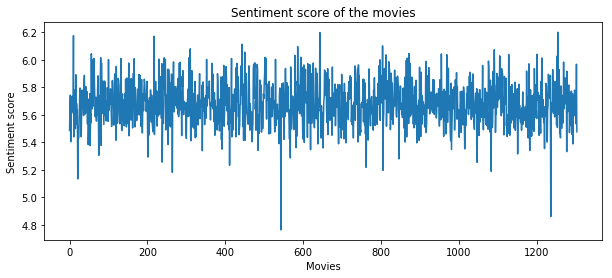

In [99]:
plot_data = [x[0] for x in movie_score_list]
plt.figure(figsize=(10,4))
plt.plot(plot_data)
plt.title("Sentiment score of the movies")
plt.xlabel("Movies")
plt.ylabel("Sentiment score")
plt.show()

We can see that the variance isn't high, the bulk of the movies fall between 5.5-5.8. But lets create a scatter plot where the y-axis will be IMDb rating of a movie and the x-axis will be the sentiment score of the movie's reviews.

We got the IMDb ratings of our movies by scraping, that code can be seen in another notebook. Here I simply get the data from a file we created.

In [100]:
imdb_rating = {}
with open('imdb-score-mod-mod.json') as json_data:
    imdb_rating = json.load(json_data)

In [101]:
#Get the ids of the 5000 movies we have in our dataset
movie_title_to_id = {}
with open('tmdb_5000_movies.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        movie_title_to_id[row['title']] = row['id']

In [102]:
#Lets create the data and store it in a list of tuples
data_to_plot = []
for i in review_dict:
    if len(review_dict[i]) > 3:
        try:
            data_to_plot.append((float(imdb_rating[movie_title_to_id[i]]),movie_score_dict[i]))
        except:
            #We'll print out the movies we can't for some reason get the rating for
            print i

xXx: State of the Union
Æon Flux


As there are only two movies we can't find the rating for we will disregard them.

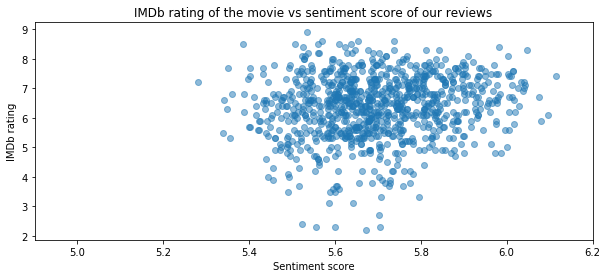

array([[ 1.        ,  0.13348281],
       [ 0.13348281,  1.        ]])

In [103]:
# Create the plot

# We start by reverse zipping the shortest_vs_human tuples array
y,x = zip(*data_to_plot)

# The we plot the result
plt.figure(figsize=(10,4))
plt.plot(x, y, "o", alpha=0.5)
plt.xlim(4.9, 6.2)
plt.title("IMDb rating of the movie vs sentiment score of our reviews")
plt.xlabel("Sentiment score")
plt.ylabel("IMDb rating")
plt.show()

np.corrcoef(x,y)

As we can see there is almost no correlation between the sentiment score of the reviews of a movie and the rating the movie receives. This was somewhat expected as the sentiment of a review tells us more about the writer of the review or perhaps the sentiment of the movie but not the rating. This shows that the IMDb reviewers are relatively smart and unbiased. Because a good 'dark' movie is still a good movie and therefore the review might be 'dark' but the rating itself is based on how good the movie is.

### Individual review sentiment score vs rating
With the dataset of reviews we get the rating of each individual review. Lets see if there is some correlation there. 

In [104]:
#We want to calculate average sentiment score of all reviews for a movie and also store the result in a dictionary
plot_data = []
tokenizer = RegexpTokenizer(r'\w+')
happiness_keys = set(happyness_rank.keys())

for movie in filename_to_review:
    sum_of_scores = 0.0
    tokens = tokenizer.tokenize(filename_to_review[movie].lower()) # Get all tokens with the tokenizer
    # filter out the stop words and digits
    filtered_words = [w for w in tokens if not w in stopwords.words('english') if not w.isdigit()]
    sum_of_scores += estimateHappiness(filtered_words,happiness_keys)
    plot_data.append((int(movie.split('_')[1].split('.')[0]), (sum_of_scores)))

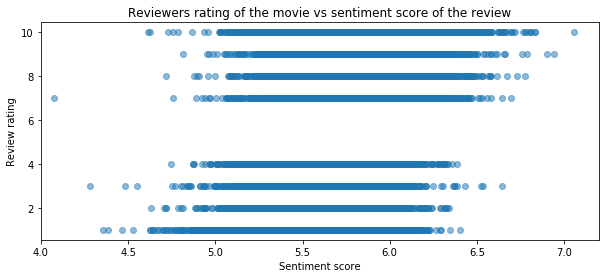

array([[ 1.        ,  0.45300539],
       [ 0.45300539,  1.        ]])

In [105]:
# Create the plot

# We start by reverse zipping the shortest_vs_human tuples array
y,x = zip(*plot_data)

# The we plot the result
plt.figure(figsize=(10,4))
plt.plot(x, y, "o", alpha=0.5)
plt.xlim(4, 7.2)
plt.title("Reviewers rating of the movie vs sentiment score of the review")
plt.xlabel("Sentiment score")
plt.ylabel("Review rating")
plt.show()

np.corrcoef(x,y)

We can see that there is some correlation but it is not high. We expected more correlation but it seems that users don't necessarily use sad words for movies they think are bad or happy words for movies they think are good.

## Conclusion

This section proved to be not that interesting and we decided to not use it in our recommendation engine. One of the main problems was the dataset, although it was quite big (100.000 reviews) it only contained review on one fourth of our movies. We could also see problems with this data above as people may talk about real life events that movies are related to instead of the movie itself. It would've been interesting to this to all reviews on IMDb for all our movies and check for correlation to rating, popularity, genre and even dates. For example are reviews written shortly before the financial crisis of 2008 much happier than the ones written shortly after? We decided however that scraping for the data needed to see more interesting result would take too long. (Scraping for just the title of each movie in this dataset took around 10 hours)